<a href="https://colab.research.google.com/github/JamesPeralta/Machine-Learning-Algorithms/blob/master/IMBD%20Move%20Review%20Classifier/Using%20Word%20Embeddings/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word embeddings

Word embeddings are low dimensional floating-pint vectors. Unlike one-hot encoding, word embeddings are learned from the data.
Word embeddings pack more information into far fewer dimensions.

### 1. Learn word embeddings jointly with the main task
In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.

In [0]:
from keras.layers import Embedding
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense

#### Loading the IMDB data for use with an Embedding layer

In [0]:
max_features = 1000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen) 
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

#### Using an Embedding layer and classifier on the IMDB data

In [0]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 82us/step - loss: 0.6772 - acc: 0.6006 - val_loss: 0.6448 - val_acc: 0.6704
Epoch 2/10
20000/20000 [==============================] - 1s 71us/step - loss: 0.5830 - acc: 0.7188 - val_loss: 0.5629 - val_acc: 0.7046
Epoch 3/10
20000/20000 [==============================] - 1s 68us/step - loss: 0.5152 - acc: 0.7463 - val_loss: 0.5362 - val_acc: 0.7208
Epoch 4/10
20000/20000 [==============================] - 1s 69us/step - loss: 0.4879 - acc: 0.7607 - val_loss: 0.5299 - val_acc: 0.7292
Epoch 5/10
20000/20000 [==============================] - 1s 69us/step - loss: 0.4731 - acc: 0.7694 - val_loss: 0.5290 - val_acc: 0.7334
Epoch 6/10
20000/20000 [==============================] - 1s 69us/step - loss: 0.4633 - acc: 0.7773 - val_loss: 0.5317 - val_acc: 0.7344
Epoch 7/10
20000/20000 [==============================] - 1s 70us/step - loss: 0.4548 - acc: 0.7820 - val_loss: 0.5333 - val_acc:

### 2. Load into your model word embeddings that were precomputed using a different machine-learning task

#### Downloading the IMDB Data as raw text

In [0]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [22]:
imdb_data = '/Users/jamesperalta/Desktop/imdb'
os.chdir(imdb_data)

os.listdir()

['.DS_Store', 'test', 'pre_trained_glove_model.h5', 'train']

#### Processing the labels of the raw IMDB data

In [0]:
train_dir = os.path.join(imdb_data, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### Tokenizing the text of the raw IMDB data

In [0]:
maxlen = 100
training_samples = 5000
validation_samples = 5000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [25]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(indices)

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)
[ 8731 13090 11393 ... 22916  6096  9424]


#### Parsing the gloVe word embeddings

In [26]:
glove_dir = '/Users/jamesperalta/Downloads/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Build an embedding matrix that I can load into an Embedding layer
* It must be a matrix of shape (max_words, embedding_dim)
* Where each entry i containts the embedding dimensional vector for that word

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

#### Model definition

In [32]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


#### Loading the pretrained word embeddings into the Embedding layer

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### Training and evaluation

In [33]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 4s 884us/step - loss: 0.6078 - acc: 0.6586 - val_loss: 0.4521 - val_acc: 0.7934
Epoch 2/10
5000/5000 [==============================] - 3s 676us/step - loss: 0.1641 - acc: 0.9554 - val_loss: 0.4424 - val_acc: 0.7988
Epoch 3/10
5000/5000 [==============================] - 3s 643us/step - loss: 0.0153 - acc: 0.9972 - val_loss: 0.5343 - val_acc: 0.7996
Epoch 4/10
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0017 - acc: 0.9994 - val_loss: 0.6397 - val_acc: 0.7926
Epoch 5/10
5000/5000 [==============================] - 4s 859us/step - loss: 6.1047e-05 - acc: 1.0000 - val_loss: 0.8306 - val_acc: 0.7882
Epoch 6/10
5000/5000 [==============================] - 3s 622us/step - loss: 1.8839e-06 - acc: 1.0000 - val_loss: 0.8298 - val_acc: 0.7972
Epoch 7/10
5000/5000 [==============================] - 3s 630us/step - loss: 1.6990e-07 - acc: 1.0000 - val_loss: 0.9205 - val_ac

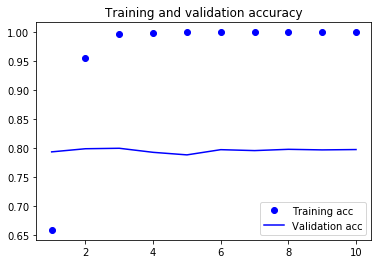

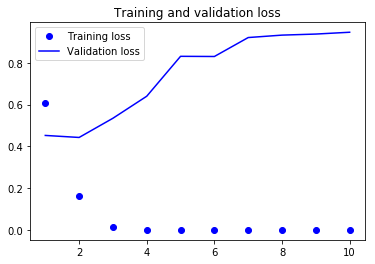

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Finally evaluate the model on the test set

In [0]:
test_dir = os.path.join(imdb_data, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            
            f.close()
            if label_type == 'neg':
              labels.append(0)
            else:
              labels.append(1)
    sequences = tokenizer.texts_to_sequences(texts)
    x_test = pad_sequences(sequences, maxlen=maxlen)
    y_test = np.asarray(labels)

In [37]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 62us/step


[0.900509215168953, 0.80252]